In [1]:
import numpy as np

# Load dataset
waveforms = np.load("waveforms.npy")
labels = np.load("labels.npy")

print("Waveforms shape:", waveforms.shape)
print("Labels shape:", labels.shape)


Waveforms shape: (5000, 2000)
Labels shape: (5000,)


In [3]:
dataset_dir = "seismic_dataset/"  # Saves in the current working directory
os.makedirs(dataset_dir, exist_ok=True)


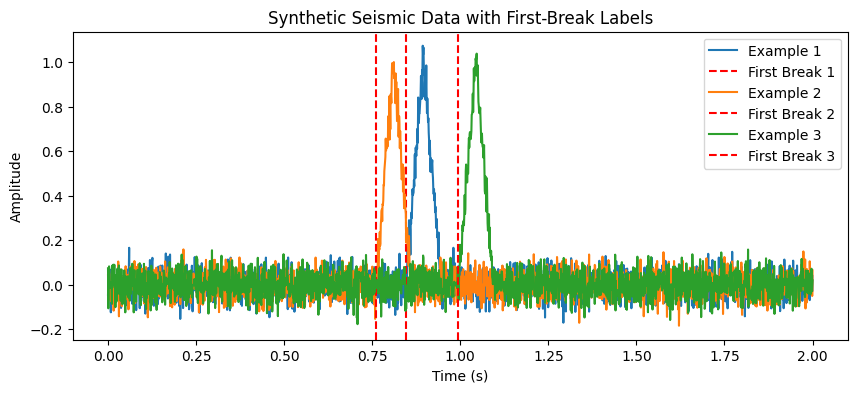

'seismic_dataset/'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os


# Parameters for synthetic data
num_samples = 5000  # Number of waveforms
sampling_rate = 1000  # Hz (samples per second)
duration = 2.0  # seconds
num_points = int(sampling_rate * duration)  # Total samples per waveform

# Generate synthetic dataset
waveforms = []
labels = []

for i in range(num_samples):
    time = np.linspace(0, duration, num_points)
    trace = np.random.normal(0, 0.05, num_points)  # Background noise

    # Random first-break time between 0.2s and 1.2s
    first_break_time = np.random.uniform(0.2, 1.2)
    first_break_index = int(first_break_time * sampling_rate)

    # Add a simulated P-wave arrival (sudden energy increase)
    trace[first_break_index:first_break_index + 50] += np.linspace(0, 1, 50)
    trace[first_break_index + 50:first_break_index + 100] += np.linspace(1, 0, 50)

    # Save waveform and label
    waveforms.append(trace)
    labels.append(first_break_index)  # First-break location in samples

# Convert to numpy arrays
waveforms = np.array(waveforms, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

# Save dataset files
np.save(os.path.join(dataset_dir, "waveforms.npy"), waveforms)
np.save(os.path.join(dataset_dir, "labels.npy"), labels)

# Plot a few examples
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.plot(time, waveforms[i], label=f"Example {i+1}")
    plt.axvline(labels[i] / sampling_rate, color="red", linestyle="--", label=f"First Break {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Synthetic Seismic Data with First-Break Labels")
plt.show()

# Return dataset path
dataset_dir


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the synthetic dataset (adjust paths to where you saved the dataset)
waveforms = np.load('large_waveforms.npy')  # Seismic waveforms
labels = np.load('large_labels.npy')  # First-break indices (labels)

# Normalize the waveforms
waveforms = (waveforms - np.min(waveforms)) / (np.max(waveforms) - np.min(waveforms))

# Reshape for CNN (batch_size, timesteps, channels)
waveforms = waveforms[..., np.newaxis]

# Split the data into training and test sets (80% for training, 20% for testing)
split_ratio = 0.8
split_index = int(len(waveforms) * split_ratio)

X_train, X_test = waveforms[:split_index], waveforms[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

# Define the SegNet-style model (using 1D CNN layers)
model = keras.Sequential([
    layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Output: first-break index
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model.save('first_break_segnet.h5')

# Plot the training history (Loss and MAE)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) during Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model on a few test samples
predictions = model.predict(X_test[:5])

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 252s 201ms/step - loss: 746576.4375 - mae: 702.0811 - val_loss: 410999.2188 - val_mae: 553.1439
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 258s 207ms/step - loss: 400575.2500 - mae: 546.1297 - val_loss: 406785.2188 - val_mae: 551.5585
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 257s 205ms/step - loss: 402660.9062 - mae: 548.5388 - val_loss: 409770.8438 - val_mae: 552.6166
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 251s 200ms/step - loss: 402827.5938 - mae: 548.9381 - val_loss: 414760.0000 - val_mae: 555.7766
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 250s 200ms/step - loss: 402455.4062 - mae: 548.3149 - val_loss: 407358.5625 - val_mae: 551.9012
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 250s 200ms/step - loss: 404442.5938 - mae: 549.9260 - val_loss: 407371.6250 - val_mae: 551.6317
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 252s 202ms/step - loss: 402476.7812 - mae: 548.7300 - val_loss: 406896.7812 - val_mae: 551.4581
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


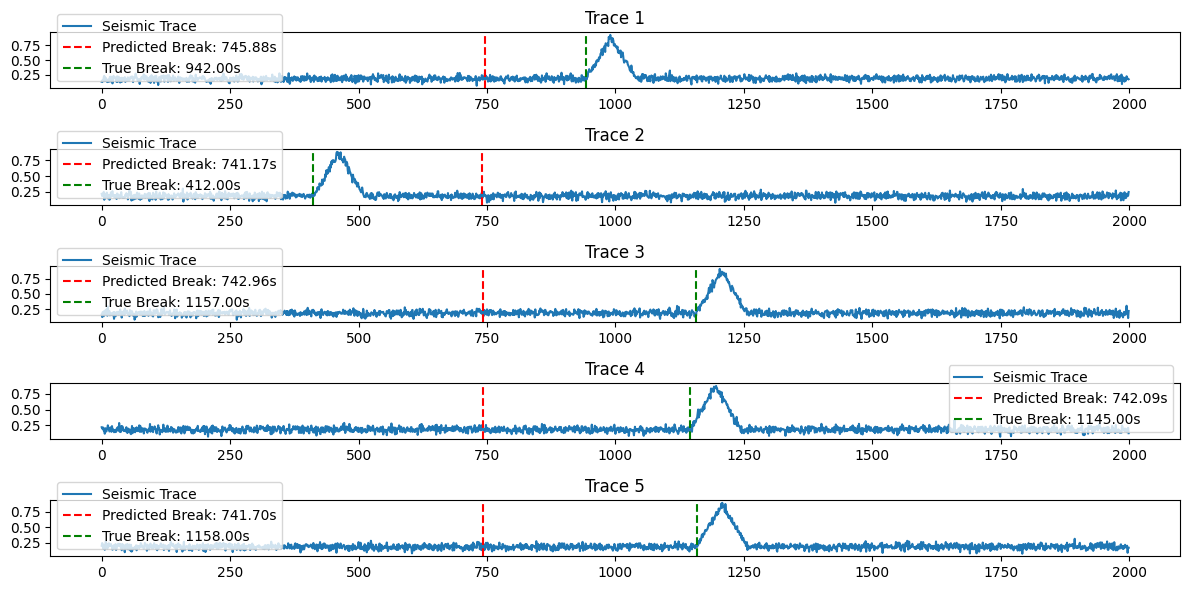

In [8]:
# Test the model on a few test samples
predictions = model.predict(X_test[:5])

# Plot predictions and true first-break indices for comparison
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(X_test[i], label='Seismic Trace')
    
    # Extract the predicted first-break index (predicted[i] is a numpy array)
    predicted_first_break = predictions[i][0]  # Get the scalar value from the prediction

    # Plot the predicted first break
    plt.axvline(predicted_first_break, color='red', linestyle='--', label=f'Predicted Break: {predicted_first_break:.2f}s')
    
    # Plot the true first break
    plt.axvline(y_test[i], color='green', linestyle='--', label=f'True Break: {y_test[i]:.2f}s')
    
    plt.legend()
    plt.title(f'Trace {i+1}')
    
plt.tight_layout()
plt.show()


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 349ms/step - loss: 534.0004 - mae: 534.5004 - val_loss: 256.4850 - val_mae: 256.9845 - learning_rate: 5.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 348ms/step - loss: 253.1574 - mae: 253.6571 - val_loss: 262.8126 - val_mae: 263.3126 - learning_rate: 5.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - loss: 258.1158 - mae: 258.6155 - val_loss: 255.5432 - val_mae: 256.0428 - learning_rate: 5.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - loss: 251.2435 - mae: 251.7432 - val_loss: 254.5307 - val_mae: 255.0303 - learning_rate: 5.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - loss: 250.1753 - mae: 250.6749 - val_loss: 254.9900 - val_mae: 255.4897 - learning_rate: 5.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 336ms/step - loss: 258.0270 - mae: 258.5269 - val_loss: 254.8745 - val_mae: 255.3741 - learning_rate: 5.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/s

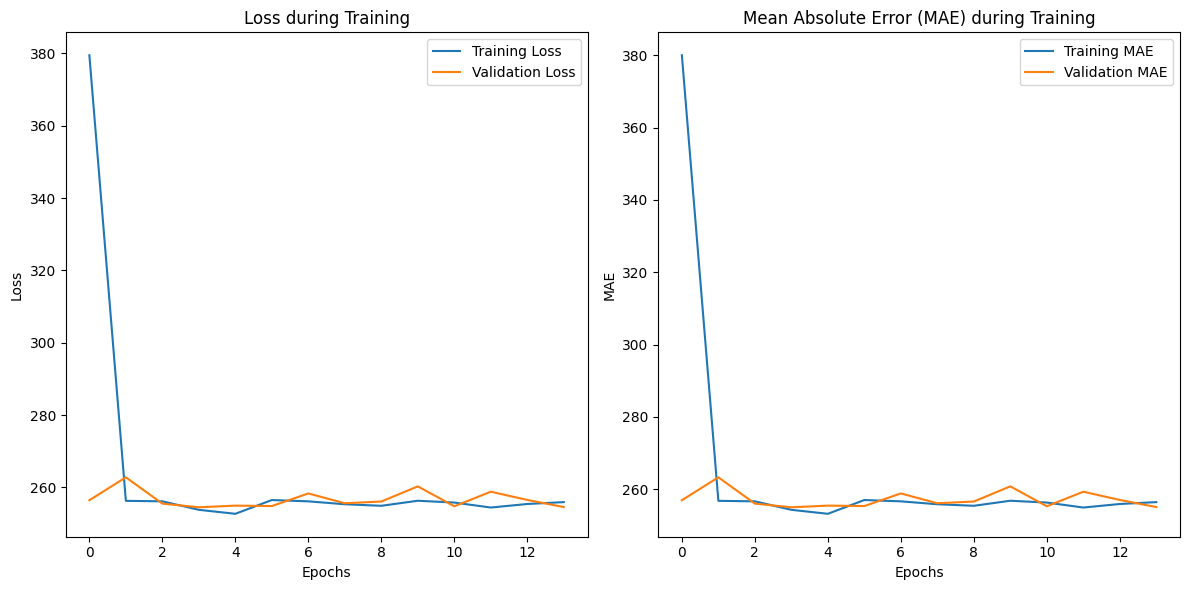

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


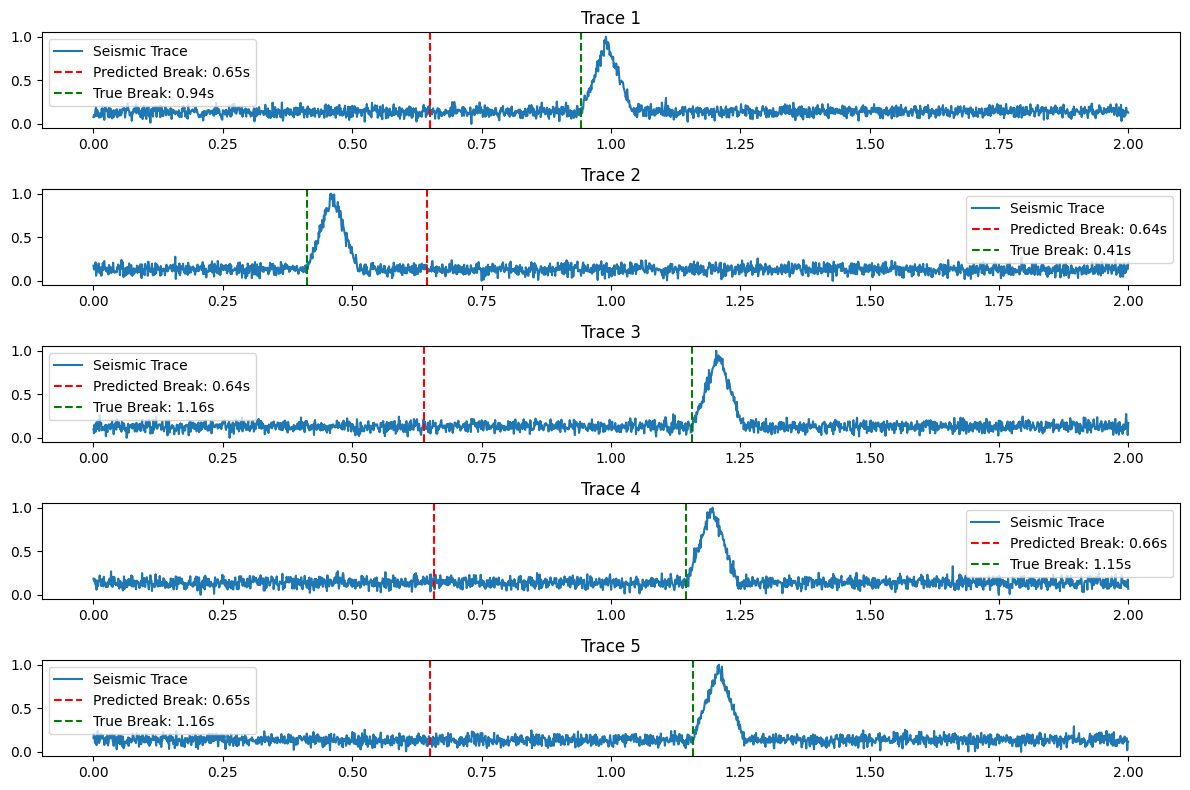

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the synthetic dataset
waveforms = np.load('waveforms.npy')  # Seismic waveforms
labels = np.load('labels.npy')  # First-break indices (labels)

# Normalize each waveform separately (improves learning stability)
waveforms = (waveforms - np.min(waveforms, axis=1, keepdims=True)) / \
            (np.max(waveforms, axis=1, keepdims=True) - np.min(waveforms, axis=1, keepdims=True) + 1e-8)

# Reshape for CNN (batch_size, timesteps, channels)
waveforms = waveforms[..., np.newaxis]

# Split the data into training and test sets (80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(waveforms) * split_ratio)

X_train, X_test = waveforms[:split_index], waveforms[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

# Define an improved CNN model
model = keras.Sequential([
    layers.Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Output: first-break index
])

# Learning rate scheduler (gradually reduces learning rate)
def scheduler(epoch, lr):
    return lr * 0.98 if epoch > 10 else lr

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)

# Early stopping (stops training if validation loss does not improve for 10 epochs)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with Huber loss (better for noisy regression)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=keras.losses.Huber(), metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_callback, early_stopping])

# Save the trained model
model.save('first_break_segnet.h5')

# Plot training history
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) during Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model on a few test samples
predictions = model.predict(X_test[:5])

# Plot predictions and true first-break indices
plt.figure(figsize=(12, 8))

sampling_rate = 1000  # Hz (samples per second)
time_axis = np.linspace(0, X_test.shape[1] / sampling_rate, X_test.shape[1])  # Convert samples to seconds

for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(time_axis, X_test[i], label='Seismic Trace')
    
    # Convert predicted and true indices to seconds
    predicted_first_break = predictions[i][0] / sampling_rate  
    true_first_break = y_test[i] / sampling_rate  

    # Plot predicted first-break index
    plt.axvline(predicted_first_break, color='red', linestyle='--', label=f'Predicted Break: {predicted_first_break:.2f}s')

    # Plot true first-break index
    plt.axvline(true_first_break, color='green', linestyle='--', label=f'True Break: {true_first_break:.2f}s')

    plt.legend()
    plt.title(f'Trace {i+1}')

plt.tight_layout()
plt.show()


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 437ms/step - loss: 489.4605 - mae: 489.9603 - val_loss: 684.9916 - val_mae: 685.4916 - learning_rate: 5.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 439ms/step - loss: 256.4330 - mae: 256.9321 - val_loss: 635.3321 - val_mae: 635.8321 - learning_rate: 5.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - loss: 256.1772 - mae: 256.6771 - val_loss: 543.7894 - val_mae: 544.2894 - learning_rate: 5.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - loss: 259.0182 - mae: 259.5181 - val_loss: 371.4942 - val_mae: 371.9942 - learning_rate: 5.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - loss: 249.1266 - mae: 249.6262 - val_loss: 262.9013 - val_mae: 263.4008 - learning_rate: 5.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - loss: 255.1734 - mae: 255.6734 - val_loss: 314.1264 - val_mae: 314.6258 - learning_rate: 5.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 424ms/s

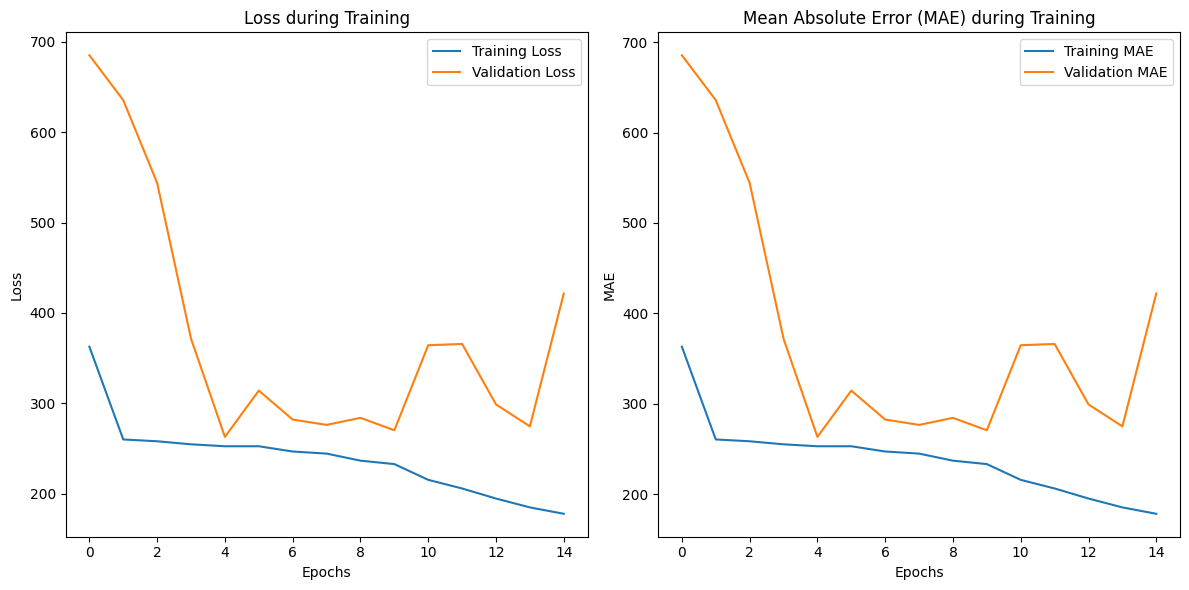

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


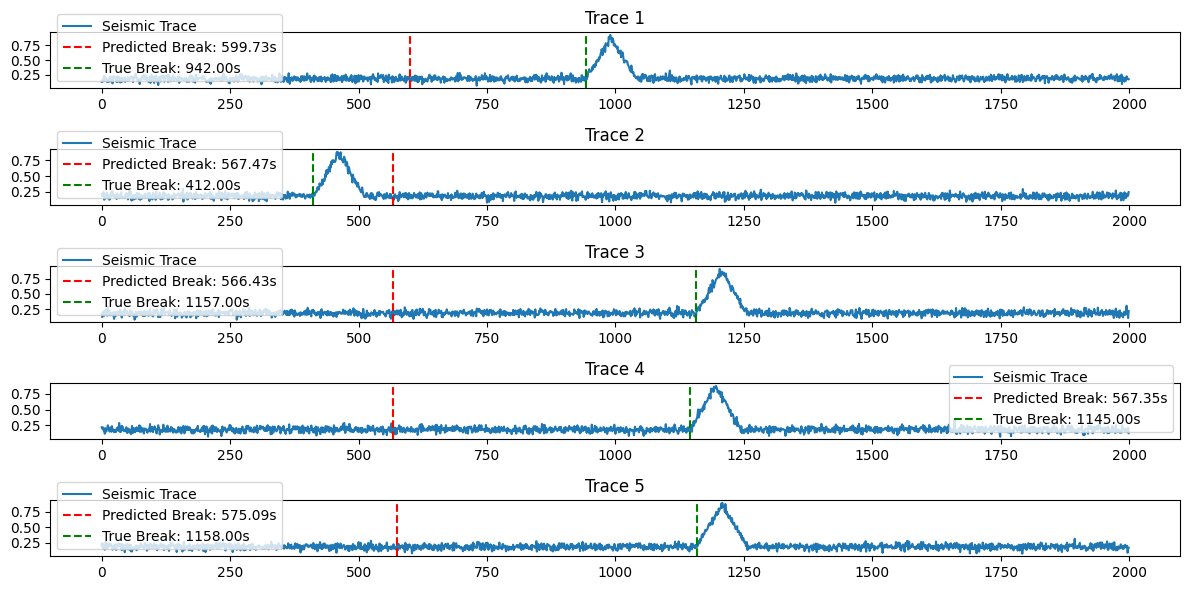

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the synthetic dataset (adjust paths to where you saved the dataset)
waveforms = np.load('waveforms.npy')  # Seismic waveforms
labels = np.load('labels.npy')  # First-break indices (labels)

# Normalize the waveforms
waveforms = (waveforms - np.min(waveforms)) / (np.max(waveforms) - np.min(waveforms))

# Reshape for CNN (batch_size, timesteps, channels)
waveforms = waveforms[..., np.newaxis]

# Split the data into training and test sets (80% for training, 20% for testing)
split_ratio = 0.8
split_index = int(len(waveforms) * split_ratio)

X_train, X_test = waveforms[:split_index], waveforms[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]

# Define the SegNet-style model (using 1D CNN layers)
model = keras.Sequential([
    layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(128, kernel_size=5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(256, kernel_size=5, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')  # Output: first-break index
])

# Compile the model with Adam optimizer and Huber loss
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss=keras.losses.Huber(), metrics=['mae'])

# Introduce callbacks for early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_callback, early_stopping])

# Save the trained model
model.save('first_break_segnet_improved.h5')

# Plot the training history (Loss and MAE)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) during Training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model on a few test samples
predictions = model.predict(X_test[:5])  # Test the model on a few test samples

# Plot predictions and true first-break indices for comparison
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(X_test[i], label='Seismic Trace')
    
    # Extract the predicted first-break index (predicted[i] is a numpy array)
    predicted_first_break = predictions[i][0]  # Get the scalar value from the prediction

    # Plot the predicted first break
    plt.axvline(predicted_first_break, color='red', linestyle='--', label=f'Predicted Break: {predicted_first_break:.2f}s')
    
    # Plot the true first break
    plt.axvline(y_test[i], color='green', linestyle='--', label=f'True Break: {y_test[i]:.2f}s')
    
    plt.legend()
    plt.title(f'Trace {i+1}')
    
plt.tight_layout()
plt.show()
